In [1]:
import copy
import networkx as nx
import heapq
import math
from scipy.spatial.distance import euclidean, cityblock
from IPPlanerBase import PlanerBase
import numpy as np
from IPEnvironment import CollisionChecker as cc 


In [22]:
class AStar(PlanerBase):
    def __init__(self, collChecker=0):
        """Contructor:

        Initialize all necessary members"""

        super(AStar, self).__init__(collChecker)
        self.graph = nx.DiGraph()  # = CloseList
        self.openList = []  # (<value>, <node>)

        self.goal = []
        self.goalFound = False

        self.limits = self._collisionChecker.getEnvironmentLimits()

        self.w = 0.5
        return

    def _getNodeID(self, pos):
        """Compute a unique identifier based on the position"""

        nodeId = "-"
        for i in pos:
            nodeId += str(i)+"-"
        return nodeId

    def planPath(self, startList, goalList, config):
        """

        Args:
            start (array): start position in planning space
            goal (array) : goal position in planning space
            config (dict): dictionary with the needed information about the configuration options

        Example:

            config["w"] = 0.5
            config["heuristic"] = "euclid"

        """
        # 0. reset
        self.graph.clear()

        # 1. check start and goal whether collision free (s. BaseClass)
        checkedStartList, checkedGoalList = self._checkStartGoal(
            startList, goalList)

        # 2.
        self.w = config["w"]
        self.heuristic = config["heuristic"]
        self.dis = config['dis']
        self.digit = config['digit']
        self.goal = checkedGoalList[0]
        self._addGraphNode(checkedStartList[0])
        self.newStart = []

        self._newStart(checkedStartList, checkedGoalList)

        checkedStartList = [self.newStart]

        print('new start: ', checkedStartList)
        currentBestName = self._getBestNodeName()
        print('currenBestName' + currentBestName)
        breakNumber = 0
        while currentBestName:
            if breakNumber > 10000/(self.dis*self.dis):  # deskratesierung paramter
                break

            breakNumber += 1

            currentBest = self.graph.nodes[currentBestName]
            # print('currenBest:', currentBest)

            if currentBest["pos"] == self.goal:
                self.solutionPath = []
                self._collectPath(currentBestName, self.solutionPath)
                self.goalFound = True
                break

            currentBest["status"] = 'closed'
            print('currentBest["pos"]: ', currentBest["pos"])
            if self._collisionChecker.pointInCollision(currentBest["pos"]):
                currentBest['collision'] = 1
                currentBestName = self._getBestNodeName()
                # print(currentBestName)
                continue

            self.graph.nodes[currentBestName]['collision'] = 0

            # handleNode merges with former expandNode
            self._handleNode(currentBestName, self.dis, self.digit)
            currentBestName = self._getBestNodeName()

        if self.goalFound:
            return self.solutionPath
        else:
            return None

    def _insertNodeNameInOpenList(self, nodeName):
        """Get an existing node stored in graph and put it in the OpenList"""
        heapq.heappush(self.openList, (self._evaluateNode(nodeName), nodeName))

    def _addGraphNode(self, pos, fatherName=None):
        """Add a node based on the position into the graph. Attention: Existing node is overwritten!"""
        self.graph.add_node(self._getNodeID(pos), pos=pos, status='open', g=0)

        if fatherName != None:
            self.graph.add_edge(self._getNodeID(pos), fatherName)
            self.graph.nodes[self._getNodeID(
                pos)]["g"] = self.graph.nodes[fatherName]["g"] + 1

        self._insertNodeNameInOpenList(self._getNodeID(pos))

    def _setLimits(self, lowLimit, highLimit):
        """ Sets the limits of the investigated search space """
        assert (len(lowLimit) == len(highLimit) == self.dim)
        self.limits = list()
        for i in range(self.dim):
            self.limits.append([lowLimit[i], highLimit[i]])
        return

    def _getBestNodeName(self):
        """ Returns the best name of best node """
        return heapq.heappop(self.openList)[1]

    def _handleNode(self, nodeName, dis, digit):
        """Generats possible successor positions in all dimensions"""
        result = []
        node = self.graph.nodes[nodeName]
        print('node', node)
        for i in range(len(node["pos"])):
            print('first loop ', i)
            for u in [- dis, dis]:
                newPos = copy.copy(node["pos"])
                newPos[i] += u
                newPos[i] = round(newPos[i], digit)

                print('u: ', u, 'newPos[i]: ', newPos[i])
                if not self._inLimits(newPos):
                    continue
                try:
                    # Do not do reopening! If node already in graph do not add it... Concequences?
                    self.graph.nodes[self._getNodeID(newPos)]
                    continue
                except:
                    pass

                self._addGraphNode(newPos, nodeName)
                print('newPos: ', newPos, 'nodeName: ', nodeName)
            print('END \n\n')
        return result

    def _computeHeuristicValue(self, nodeName):
        """ Computes Heuristic Value: Manhattan Distance """

        result = 0
        node = self.graph.nodes[nodeName]
        if self.heuristic == "euclidean":
            return euclidean(self.goal, node["pos"])
        else:
            return cityblock(self.goal, node["pos"])

    def _evaluateNode(self, nodeName):
        node = self.graph.nodes[nodeName]
        return self.w * self._computeHeuristicValue(nodeName) + (1 - self.w) * node["g"]

    def _collectPath(self, nodeName, solutionPath):

        fathers = list(self.graph.successors(nodeName))
        # print len(fathers)
        if len(fathers) == 1:
            self._collectPath(fathers[0], solutionPath)
        elif len(fathers) == 0:
            solutionPath.append(nodeName)
            return
        else:
            raise Exception(
                "not suitable numbers of fathers = {}.... please check".format(len(fathers)))
        solutionPath.append(nodeName)
        return

    def _inLimits(self, pos):
        result = True
        for i, limit in enumerate(self.limits):
            if pos[i] < limit[0] or pos[i] > limit[1]:
                result = False
                break
        return result

    def _newStart(self, startList, goalList):

        startList = np.array(startList[0], dtype='float16')
        goalList = np.array(goalList[0], dtype='float16')

        self.var = [startList[0] - goalList[0], startList[1] - goalList[1]]

        if self.var[0] % self.dis > 0.00000000:
            self.newStart.append(
                round(((self.dis - round((self.var[0] % self.dis),self.digit)) + startList[0]), self.digit))
        else:
            self.newStart.append(startList[0])
        if self.var[1] % self.dis > 0.00000000:
            self.newStart.append(
                round(((self.dis - round((self.var[0] % self.dis),self.digit)) + startList[1]), self.digit))
        else:
            self.newStart.append(startList[1])

        print(self._collisionChecker.lineInCollision(startList, goalList))
        return


In [3]:
newStart = []
def get(number , dis):
    origin = number
    result = 0

    while (number - dis) >= 0:
        number = number - dis
        result = result +1 

    reminder = round((origin - (result * dis)),5)
    # reminder = number
    
    return {result , reminder}


def _newStart(startList, goalList , dis , digit ):

    # startList = np.array(startList[0], dtype='float16')
    # goalList = np.array(goalList[0], dtype='float16')
    startList = startList[0]
    goalList = goalList[0]

    newStart.append(Decimal(startList[0])-(round(np.mod(Decimal(startList[0]),Decimal(dis)),5)))
    print(round(np.mod(Decimal(startList[0]),Decimal(dis)),5))
    print(Decimal(newStart[0])%Decimal(dis))
    return newStart


start = [[4.5, 0]]
goal = [[1, 1]]

# print(_newStart(start, goal , 0.3 , 4))
print(get(5 , 0.1))


{0.0, 50}


In [3]:
def aStarVisualize(planner, solution, ax = None, nodeSize = 300):
    graph = planner.graph
    collChecker = planner._collisionChecker
    # get a list of positions of all nodes by returning the content of the attribute 'pos'
    pos = nx.get_node_attributes(graph,'pos')
    color = nx.get_node_attributes(graph,'color')
    
    # get a list of degrees of all nodes
    #degree = nx.degree_centrality(graph)
    
    # draw graph (nodes colorized by degree)
    open_nodes = [node for node,attribute in graph.nodes(data=True) if attribute['status']=="open"]
    draw_nodes = nx.draw_networkx_nodes(graph, pos, node_color='#FFFFFF', nodelist=open_nodes, ax = ax, node_size=nodeSize)
    draw_nodes.set_edgecolor("b")
    open_nodes = [node for node,attribute in graph.nodes(data=True) if attribute['status']=="closed"]
    draw_nodes = nx.draw_networkx_nodes(graph, pos, node_color='#0000FF', nodelist=open_nodes, ax = ax, node_size=nodeSize)
    #nx.draw_networkx_nodes(graph, pos,  cmap=plt.cm.Blues, ax = ax, node_size=nodeSize)
    nx.draw_networkx_edges(graph,pos,
                               edge_color='b',
                               width=3.0
                            )
    
    collChecker.drawObstacles(ax)
    
    # draw nodes based on solution path
    Gsp = nx.subgraph(graph,solution)
    nx.draw_networkx_nodes(Gsp,pos,
                            node_size=nodeSize,
                             node_color='g')
        
    # draw edges based on solution path
    nx.draw_networkx_edges(Gsp,pos,alpha=0.8,edge_color='g',width=10,arrows=True)
 
    nx.draw_networkx_nodes(graph,pos,nodelist=[solution[0]],
                           node_size=300,
                           node_color='#00dd00',  ax = ax)
    nx.draw_networkx_labels(graph,pos,labels={solution[0]: "S"},  ax = ax)


    nx.draw_networkx_nodes(graph,pos,nodelist=[solution[-1]],
                                   node_size=300,
                                   node_color='#DD0000',  ax = ax)
    nx.draw_networkx_labels(graph,pos,labels={solution[-1]: "G"},  ax = ax)


In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

from shapely.geometry import Point, Polygon, LineString
from IPEnvironment import CollisionChecker

# Definition of a testing environment
trapField = dict()
trapField["obs1"] =   LineString([(6, 18), (6, 8), (16, 8), (16,18)]).buffer(1)

environment = CollisionChecker(trapField)


start = [[0,0]]
goal  = [[1, 1]]

# AStar
astar = AStar(environment)

# To know what is part on the config please consult the documentation of planPath
astarConfig = dict()
astarConfig["w"] = .5
astarConfig["heuristic"]  = "euclidean"
astarConfig["dis"]  = 0.3
astarConfig["digit"]  = 4



solution = astar.planPath(start, goal, astarConfig)
print(astar.graph)

False
new start:  [[0.1, 0.1]]
currenBestName-0-0-
currentBest["pos"]:  [0, 0]
node {'pos': [0, 0], 'status': 'closed', 'g': 0, 'collision': 0}
first loop  0
u:  -0.3 newPos[i]:  -0.3
u:  0.3 newPos[i]:  0.3
newPos:  [0.3, 0] nodeName:  -0-0-
END 


first loop  1
u:  -0.3 newPos[i]:  -0.3
u:  0.3 newPos[i]:  0.3
newPos:  [0, 0.3] nodeName:  -0-0-
END 


currentBest["pos"]:  [0, 0.3]
node {'pos': [0, 0.3], 'status': 'closed', 'g': 1, 'collision': 0}
first loop  0
u:  -0.3 newPos[i]:  -0.3
u:  0.3 newPos[i]:  0.3
newPos:  [0.3, 0.3] nodeName:  -0-0.3-
END 


first loop  1
u:  -0.3 newPos[i]:  0.0
newPos:  [0, 0.0] nodeName:  -0-0.3-
u:  0.3 newPos[i]:  0.6
newPos:  [0, 0.6] nodeName:  -0-0.3-
END 


currentBest["pos"]:  [0.3, 0]
node {'pos': [0.3, 0], 'status': 'closed', 'g': 1, 'collision': 0}
first loop  0
u:  -0.3 newPos[i]:  0.0
newPos:  [0.0, 0] nodeName:  -0.3-0-
u:  0.3 newPos[i]:  0.6
newPos:  [0.6, 0] nodeName:  -0.3-0-
END 


first loop  1
u:  -0.3 newPos[i]:  -0.3
u:  0.3 newP

IndexError: index out of range

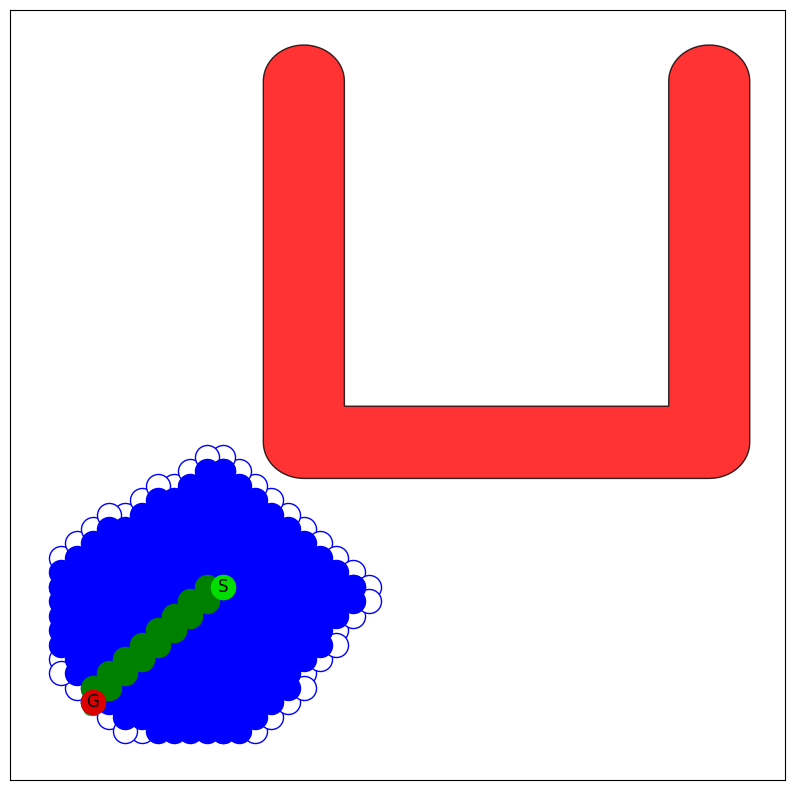

In [20]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1,1,1)

aStarVisualize(astar, solution, ax = ax)